# Anomaly Detection

> In this notebook, we'll implement anomaly detection in time series data 


## Prerequesites

This tutorial assumes basic familiarity with MLForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/mlforecast/docs/quick_start_local.html) 


## Introduction 

Anomaly detection is a crucial task in time series forecasting. It involves identifying unusual observations that don't follow the expected dataset patterns. Anomalies, also known as outliers, can be caused by a variety of factors, such as errors in the data collection process, sudden changes in the underlying patterns of the data, or unexpected events. They can pose problems for many forecasting models since they can distort trends, seasonal patterns, or autocorrelation estimates. As a result, anomalies can have a significant impact on the accuracy of the forecasts, and for this reason, it is essential to be able to identify them. Furthermore, anomaly detection has many applications across different industries, such as detecting fraud in financial data, monitoring the performance of online services, or identifying usual patterns in energy usage.

By the end of this tutorial, you'll have a good understanding of how to detect anomalies in time series data using [MLForecast](https://github.com/Nixtla/mlforecast)'s probabilistic models. 

**Outline:**

1. Install libraries 
2. Load and explore data 
3. Train model 
4. Recover insample forecasts and identify anomalies

::: {.callout-important}

## Important 

Once an anomaly has been identified, we must decide what to do with it. For example, we could remove it or replace it with another value. The correct course of action is context-dependent and beyond this notebook's scope. Removing an anomaly will likely improve the accuracy of the forecast, but it can also underestimate the amount of randomness in the data.  
You can also use anomaly detection to detect potential issues in your data, an anomaly in a machine time series could imply a malfunction.
:::

:::{.callout-tip}
You can use Colab to run this Notebook interactively
:::

## Install libraries 

We assume that you have `MLForecast` already installed. If not, check this guide for instructions on [how to install mlforecast](https://nixtla.github.io/mlforecast/docs/install.html) 

Install the necessary packages using `pip install mlforecast`

In [1]:
#!pip install mlforecast -U

## Load and explore the data 

For this example, we'll use the hourly dataset of the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). We'll first import the data from [datasetsforecast](https://github.com/Nixtla/datasetsforecast/tree/main/), which you can install using `pip install datasetsforecast`

In [2]:
#!pip install datasetsforecast -U 

In [3]:
from datasetsforecast.m4 import M4 

The function to load the data is `M4.load`. It requieres the following two arguments: 

- `directory`: (str) The directory where the data will be downloaded. 
- `group`: (str). The group name, which can be `Yearly`, `Quarterly`, `Monthly`, `Weekly`, `Daily` or `Hourly`. 

This function returns multiple outputs, but only the first one with the target series is needed. 

In [4]:
df_total, *_ = M4.load('./data', 'Hourly')
df_total.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to MLForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `df` and `y`. The names of the columns can vary, as long as you pass the correct name as an argument to the `NixtlaVerse` functions.

- `unique_id`: (string, int or category) A unique identifier for the series. 
- `ds`: (datestamp or int) A datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS or an integer indexing time. 
- `y`: (numeric) The measurement we wish to forecast. 

In this case, the `unique_id` and `y` columns already have the requiered format, but we need to change the data type of the `ds` column.  

In [5]:
df_total['ds'] = df_total['ds'].astype(int)

From this dataset, we'll select the first 8 time series to reduce the total execution time. You can select any number you want by changing the value of `n_series`. 

In [6]:
n_series = 2
uids = df_total['unique_id'].unique()[:n_series]
df = df_total.query('unique_id in @uids')
df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


Note that the `ds` ( `time_column` ) has integers instead of timestamps. MLForecast can easily handle these types of indexing. Yet, for modeling is a good idea to know the exact frequency of the series, which in our case is hourly (H).

We can plot these series using the [`plotting.plot_series`](https://nixtla.github.io/utilsforecast/plotting.html) method from the [utilsforecast library](https://nixtla.github.io/utilsforecast/). You can install the library by using:  
`pip install utilsforecast`

In [7]:
#!pip install utilsforecast

This method has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A pandas dataframe with columns [id_col, time_col, target_col].
- `id_col`: (str = 'unique_id') Column that identifies each series.
- `time_col`: (str = 'ds') Column that identifies each timestep, its values can be timestamps or integers.
- `target_col`: (str = 'y') Column that contains the target.  

Additionally you can pass more arguments to the function including the forecast results so it can plot them:  
- `forecasts_df`: A pandas dataframe with columns [id_col, time_col] and models.
- `ids`: (list[str]) Time Series to plot.If None, time series are selected randomly. 
- `plot_random`: (bool = True) Plots the time series randomly.
- `max_ids`: (int = 8) Maximum number of ids to plot
- `plot_anomalies`: (bool = False) Plots anomalies for each prediction interval. 

In [8]:
from utilsforecast.plotting import plot_series

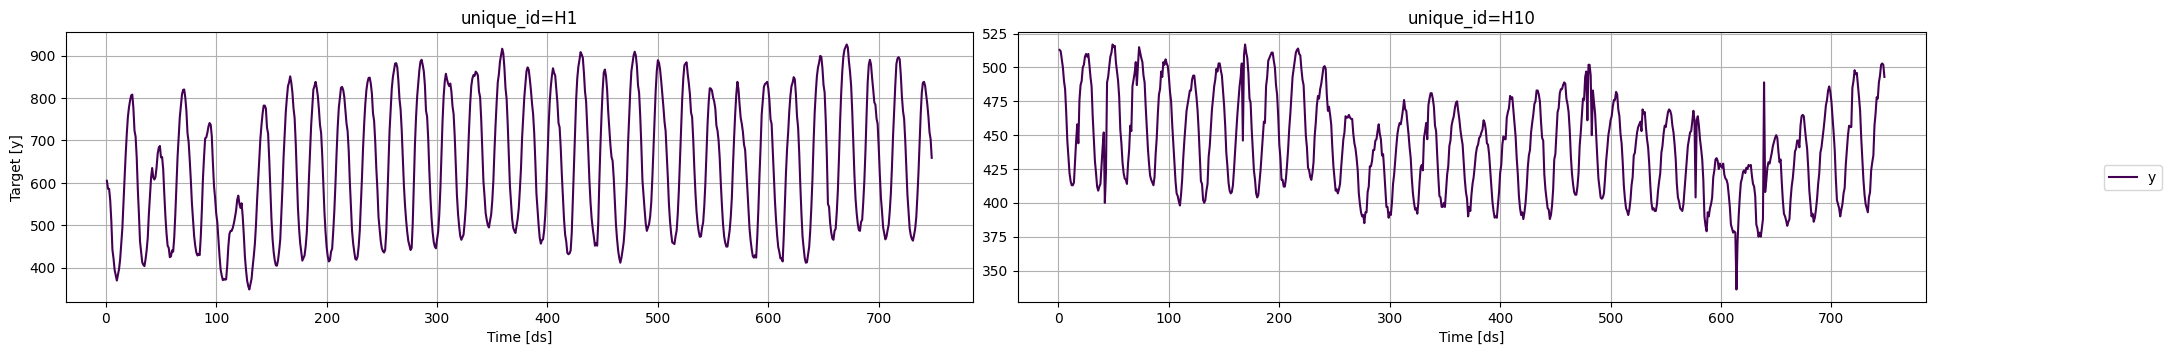

In [9]:
plot_series(
        df=df,
        id_col = 'unique_id', # id column
        time_col= 'ds', # time column
        target_col = 'y' # target column
        )

## Train model 

### Seasonalities and Differences

Since we're using hourly data ('H') and it seems to have seasonality every 24 hours (daily). Hence, we can apply target transformations that take into account this strong seasonalities.  
This can be done with the `mlforecast.target_transforms.Differences` transformer, which we pass through `target_transforms` argument to the `mlforecast.MLForecast` object.  
  
We are going to analize the `MLForecast` object in more detail in the next sections, for now we will just use it for plotting.

In [10]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

In order to analize the trends we are going to plot them individually and combined. Therefore, we can compare them against the original series. We can use the next function for that.  

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
# Assuming you also have required imports for MLForecast and Differences

def plot_differences(df, differences, number_of_periods,fname):
    prep = [df]
    # Plot combined Differences
    fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq=1,  # our series have hourly frequency denoted by integers
        target_transforms=[Differences(differences)],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)

    unique_ids = prep['unique_id'].apply(lambda x: x.replace('_all_diff','')).unique()
    n_series = len(unique_ids)
    fig, ax = plt.subplots(nrows=n_series, ncols=2, figsize=(14, 5 * n_series))

    # Plot original and differences side by side
    for i, title in enumerate(unique_ids):
        # Original
        original_df = df[df['unique_id'] == title]
        original_df = original_df.sort_values('ds', ascending=False).tail(number_of_periods)
        original_ax = original_df.set_index('ds')['y'].plot(title=f"{title}_original", ax=ax[i, 0])

        # Differences
        diff_df = prep[prep['unique_id'] == f'{title}_all_diff']
        diff_df = diff_df.sort_values('ds', ascending=False).tail(number_of_periods)
        diff_ax = diff_df.set_index('ds')['y'].plot(title=title, ax=ax[i, 1])

        # Calculate common y-axis limits
        y_min = min(original_ax.get_ylim()[0], diff_ax.get_ylim()[0])
        y_max = max(original_ax.get_ylim()[1], diff_ax.get_ylim()[1])

        # Set common y-axis limits
        original_ax.set_ylim(y_min, y_max)
        diff_ax.set_ylim(y_min, y_max)

    fig.savefig(f'../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

# You might need to adjust some parts based on the structure of your dataframe and the expected behavior. 


As you can see in the next plots, the series seem to stabilize. Yet, some series seem less stable than the others sisnce they present high variability at some points (peaks and depressions)

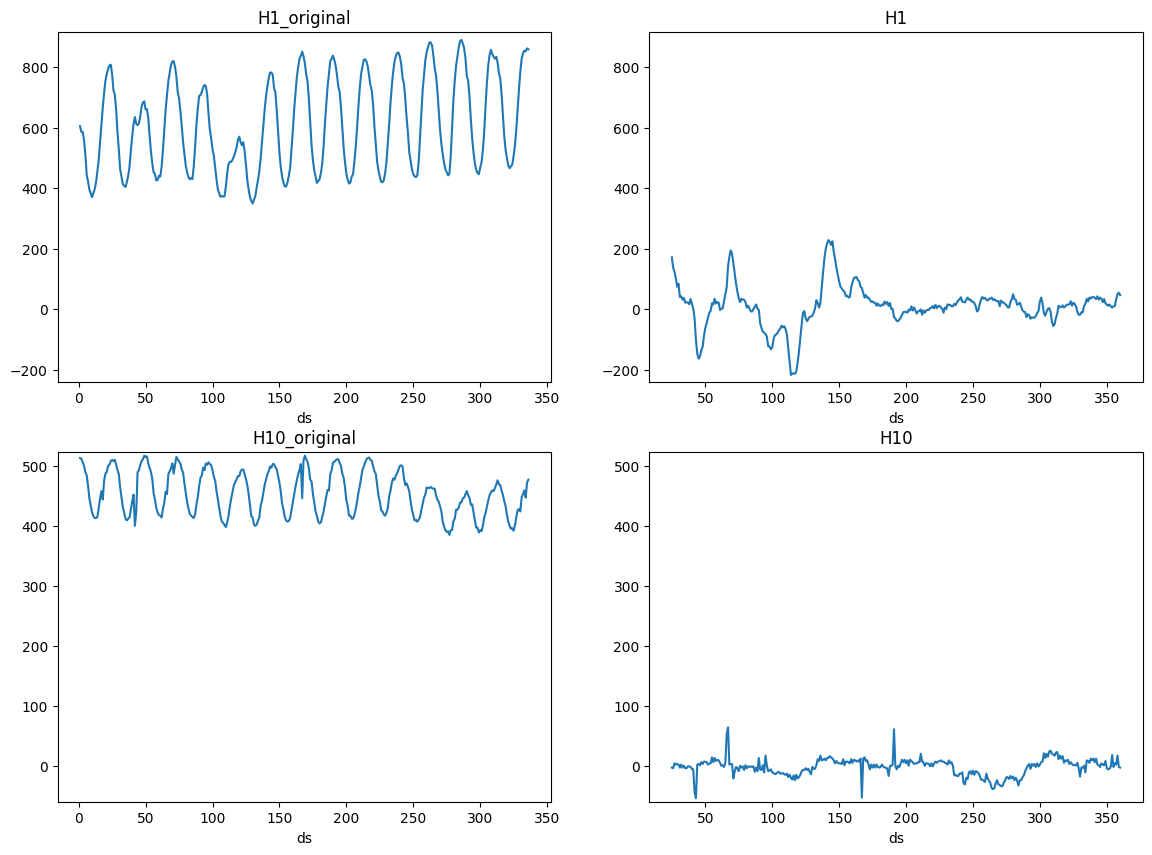

In [12]:
plot_differences(
                df=df, 
                differences=[24], # Differences to apply
                number_of_periods=24*14, # Number of periods to plot
                fname='anomaly_detection__differences.png' # Filename to save the plot
                )

### Training a Forecasting Model

To generate the forecast, we'll use the [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) model alongside MLForecast. We first need to import it from the `lightgbm` library. MLForecast also allows us to use any model from the [scikit-learn library](https://scikit-learn.org/stable/modules/classes.html).


In [13]:
import lightgbm as lgb

We are goiing to create some prediction intervals to identify anomalies. For that we can use the [`PredictionIntervals`](https://nixtla.github.io/mlforecast/utils.html#predictionintervals) function in `mlforecast.utils`. You can see an in-depth tutotorial of [Probabilistic Forecasting here](https://nixtla.github.io/mlforecast/docs/prediction_intervals.html). 

In [14]:
from mlforecast.utils import PredictionIntervals

To instantiate a new [MLForecast object](https://nixtla.github.io/mlforecast/forecast.html#mlforecast), we need the following parameters:

- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `lags`: (list[str]) Lags of the target to use as features.
- `target_transforms`: [(see TargetTransform)](https://nixtla.github.io/mlforecast/target_transforms.html) Transformations that will be applied to the target before computing the features and restored after the forecasting step.

In [15]:
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean
from sklearn.linear_model import Lasso

mlf = MLForecast(
    models = [lgb.LGBMRegressor()], # Models
    #models = [Lasso(alpha=2,max_iter=3000), lgb.LGBMRegressor(n_estimators=100)],
    freq = 1, # Frequency
    #lags=range(1,25,1), # Lags to be used as features
    target_transforms=[Differences([24])], #  Target transforms
    lag_transforms={
        1: [expanding_mean],
        2: [expanding_mean],
        #1: [(ewm_mean, 4), (rolling_mean, 24), (rolling_mean, 48), expanding_mean],
        #2: [(ewm_mean, 4), (rolling_mean, 24), (rolling_mean, 48), expanding_mean],
        #6: [(ewm_mean, 4), (rolling_mean, 4)],
        #12: [(ewm_mean, 4), (rolling_mean, 4)],
        #18: [(ewm_mean, 4), (rolling_mean, 4)],
        24: [(ewm_mean, 4), (rolling_mean, 4)],
        #36: [(ewm_mean, 4), (rolling_mean, 4)],
        #48: [(ewm_mean, 4), (rolling_mean, 4)],
        #24*7: [(ewm_mean, 4), (rolling_mean, 4)],
        # 2: [(rolling_mean, 24), expanding_mean],
        # 24: [(ewm_mean, 4)],
    }
)

Now we’re ready to generate the point forecasts and the prediction intervals. To do this, we’ll use the (cross_validation)[https://nixtla.github.io/mlforecast/forecast.html#mlforecast.cross_validation] method, which takes the following arguments:

+ `df`: Series data in long format.
+ `h`: Forecast horizon.
+ `n_windows`:  Number of windows to evaluate.
+ `step_size`: Step size between each cross validation window. If None it will be equal to `h`.
+ `prediction_intervals`: (PredictionIntervals) Configuration to calibrate prediction intervals (Conformal Prediction).
+ `level`: (list[int]) Confidence levels between 0 and 100 for prediction intervals.
+ `fitted`: (bool = False) Save in-sample predictions.  
  
Additionally we can specify the name of the columns that specify our data with the next arguments:
+ `id_col`: (str='unique_id') Column that identifies each series. In our case, unique_id.
+ `time_col`: (str='ds') Column that identifies each timestep, its values can be timestamps or integers. In our case, ds.
+ `target_col`: (str='y') Column that contains the target. In our case, y.

 The `PredictionIntervals` function is used to compute prediction intervals for the models using [Conformal Prediction](https://valeman.medium.com/how-to-predict-full-probability-distribution-using-machine-learning-conformal-predictive-f8f4d805e420). The function takes the following arguments:
+ `h`: the forecast horizon  

In [37]:
cross_validation_data = mlf.cross_validation(
    df = df,
    h=24,
    n_windows=4,
    prediction_intervals=PredictionIntervals(n_windows=4, h=24),
    level = [90],
    fitted=True # To save the in-sample predictions
)
cross_validation_data.head()

/home/uumami/miniconda3/envs/nixtla-mlf-dev/lib/python3.10/site-packages/mlforecast/forecast.py:724: UserWarning: Excuting `cross_validation` after `fit` can produce unexpected errors
  warnings.warn(
/home/uumami/miniconda3/envs/nixtla-mlf-dev/lib/python3.10/site-packages/mlforecast/forecast.py:724: UserWarning: Excuting `cross_validation` after `fit` can produce unexpected errors
  warnings.warn(
/home/uumami/miniconda3/envs/nixtla-mlf-dev/lib/python3.10/site-packages/mlforecast/forecast.py:724: UserWarning: Excuting `cross_validation` after `fit` can produce unexpected errors
  warnings.warn(
/home/uumami/miniconda3/envs/nixtla-mlf-dev/lib/python3.10/site-packages/mlforecast/forecast.py:724: UserWarning: Excuting `cross_validation` after `fit` can produce unexpected errors
  warnings.warn(
/home/uumami/miniconda3/envs/nixtla-mlf-dev/lib/python3.10/site-packages/mlforecast/forecast.py:724: UserWarning: Excuting `cross_validation` after `fit` can produce unexpected errors
  warnings.w

,unique_id,ds,cutoff,y,LGBMRegressor,LGBMRegressor-lo-90,LGBMRegressor-hi-90
0,H1,653,652,664.0,638.690051,598.412400,678.967702
1,H1,654,652,550.0,573.805706,526.801355,620.810057
2,H1,655,652,544.0,522.448256,476.373818,568.522694
3,H1,656,652,505.0,474.452890,428.519496,520.386284
4,H1,657,652,483.0,445.491065,401.770967,489.211163


In [39]:
anomalies = cross_validation_data[(cross_validation_data['y'] > cross_validation_data['LGBMRegressor-hi-90']) | 
                                      (cross_validation_data['y'] < cross_validation_data['LGBMRegressor-lo-90'])]
anomalies.head()

,unique_id,ds,cutoff,y,LGBMRegressor,LGBMRegressor-lo-90,LGBMRegressor-hi-90
15,H1,668,652,898.0,816.662438,768.519763,864.805114
16,H1,669,652,914.0,823.156287,772.400856,873.911718
35,H10,664,652,412.0,375.072160,352.703378,397.440943
36,H10,665,652,418.0,370.366704,344.443003,396.290404
37,H10,666,652,427.0,389.741609,372.891555,406.591662


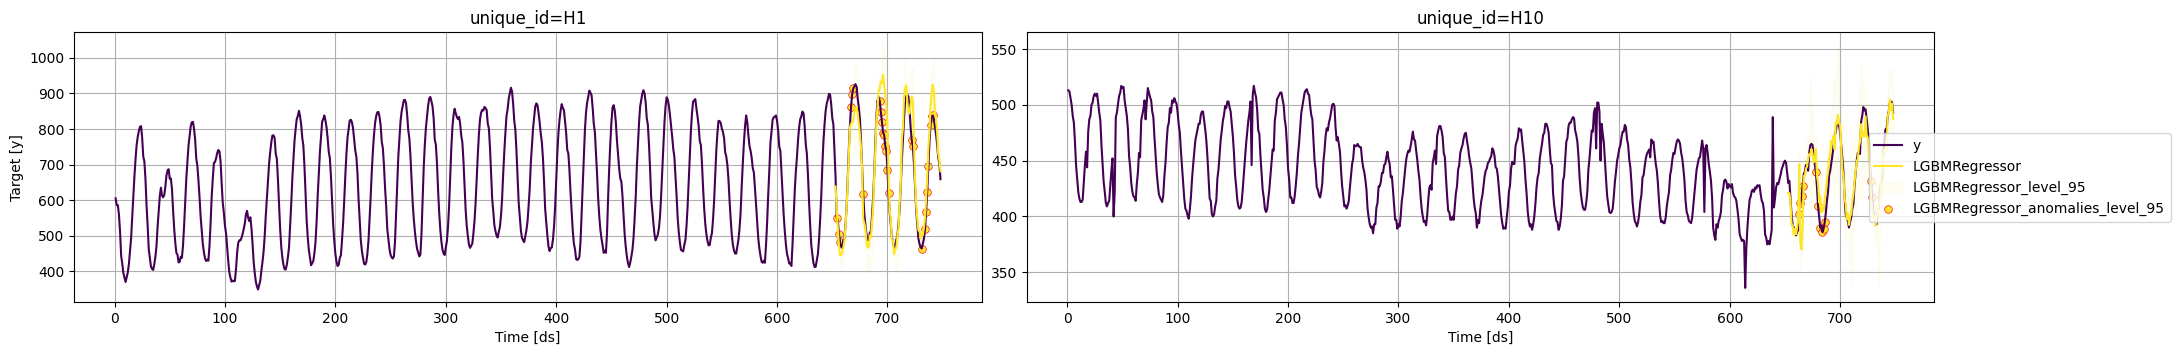

In [20]:
plot_series(
        df = df[(df['ds'] < 652)],
        forecasts_df=cross_validation_data[['unique_id','ds','y','LGBMRegressor', 'LGBMRegressor-hi-95', 'LGBMRegressor-lo-95']],
        plot_anomalies = True,
        level=[95],
        models = ['LGBMRegressor'],
        id_col = 'unique_id', # id column
        time_col= 'ds', # time column
        target_col = 'y' # target column
        )